In [2]:
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

from datetime import date, datetime, timedelta, UTC
import os
import time
import shutil

import neuralprophet
from neuralprophet import NeuralProphet
from binance.client import Client

from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error

torch.serialization.add_safe_globals([neuralprophet.configure.ConfigSeasonality])
print("NeuralProphet version:", neuralprophet.__version__)
print("Loaded from:", neuralprophet.__file__)
print("PyTorch version:", torch.__version__)
print("PyTorch Lightning version:", pl.__version__)

NeuralProphet version: 0.8.0
Loaded from: /home/lex/Documents/Jupyter/myenv/lib/python3.12/site-packages/neuralprophet/__init__.py
PyTorch version: 2.7.1+cu126
PyTorch Lightning version: 2.5.2


In [3]:
client = Client()
#os.makedirs(os.path.join('..', 'charts'), exist_ok=True)

In [4]:
def get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '12 days'):
    now = datetime.now(UTC)
    past = now - pd.to_timedelta(lookback)

    df = pd.DataFrame(client.get_historical_klines(symbol, interval, str(past), str(now)
    ), columns=['open_time','Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol','is_best_match'])
    
    df['Date']= pd.to_datetime(df['close_time'], unit='ms')
    return df[['Date','Open', 'High', 'Low', 'Close', 'Volume']]  


def safe_get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '12 days', max_retries=10, base_delay=5):
    retries = 0
    while True:
        try:
            return get_binance_data(interval=interval, lookback=lookback)
        except Exception as e:
            retries += 1
            if retries >= max_retries:
                raise RuntimeError(f"Max retries reached. Last error: {e}")
            delay = base_delay * (2 ** (retries - 1))  # Exponential backoff
            print(f"Error: {e}. Retrying in {delay} sec...")
            time.sleep(delay)


In [5]:
%%time
symbol='BTCUSDT'
data = safe_get_binance_data(symbol=symbol, interval='5m', lookback = '20 days')
data.to_csv('Data_set_for_analitics_5min.csv')

CPU times: user 88.2 ms, sys: 10.8 ms, total: 99 ms
Wall time: 4.89 s


In [7]:
# Step 1: Clean raw data

df_train = data[['Date', 'Close']].dropna(subset=['Close']).copy()

# Step 2: Ensure correct data types
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.astype({'Close': 'float'})

# Step 3: Rename columns for Prophet
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})

# Step 4: Remove extreme outliers
q_low = df_train['y'].quantile(0.005)
q_high = df_train['y'].quantile(0.995)
df_train = df_train[(df_train['y'] >= q_low) & (df_train['y'] <= q_high)]

df_train = df_train.iloc[-3000:].copy().reset_index(drop=True) #drop=True prevents it from being added as a column


In [6]:
# Testing
horizont = 180

if os.path.exists(".neuralprophet"):
    shutil.rmtree(".neuralprophet")
    
df_train = data[['Date', 'Close']].dropna(subset=['Close']).copy()
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.astype({'Close': 'float'})
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})
q_low = df_train['y'].quantile(0.005)
q_high = df_train['y'].quantile(0.995)
df_train = df_train[(df_train['y'] >= q_low) & (df_train['y'] <= q_high)]

df_test = df_train.iloc[-3000:-horizont].copy()

df_train = df_train.iloc[-3000:].copy()

model_param ={
    "n_changepoints": 120, # fewer changepoints speed up predictions
    "daily_seasonality": True,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "trend_reg": 1 / 0.04,
    "seasonality_reg": 1 / 20.0,
    "growth": "linear",
    "trainer_kwargs": {
        "enable_checkpointing": False  # disables saving/loading checkpoints
    }
}
m = NeuralProphet(**model_param)  #**model_param


m.add_country_holidays(country_name='US')
m.add_seasonality(name='custom_weekly', period=7, fourier_order=3)
m.add_seasonality(name='hourly', period=1/24, fourier_order=2)


metrics = m.fit(df_test, freq='5min')

#Create future dataframe
future = m.make_future_dataframe(df_test, periods=90)
forecast = m.predict(future)

true_y = df_train['y'].iloc[-horizont:]
predict_y = forecast['yhat1'].iloc[-horizont:]

mae = mean_absolute_error(true, predict) # mean absolute error
percent_mae = (mae / np.mean(true_y)) * 100
rmse = np.sqrt(mean_squared_error(true_y, predict_y))  # Root Mean Squared Error
print(f'MAE = {mae}')
print(f'Percent mae = {percent_mae}')
print(f'RMSE = {rmse}')

TypeError: NeuralProphet.__init__() got an unexpected keyword argument 'trainer_kwargs'

In [28]:
# Forecasting
## Creating model parameters
model_param ={
    "n_changepoints": 120, # fewer changepoints speed up predictions
    "daily_seasonality": True,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "changepoint_prior_scale": 0.04,
    "seasonality_prior_scale": 20.0,
    "holidays_prior_scale": 10.0,
    "growth": "logistic" #or linear.Then will need to delete cap paremeter/linear is by default
}
m = Prophet(**model_param)  #**model_param
df_train['cap']= df_train["y"].max() + df_train["y"].std() * 0.05
m.add_country_holidays(country_name='US')
m.add_seasonality(name='dayly', period=1, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_seasonality(name='hourly', period=1/24, fourier_order=2) 

# Fit model
metrics = m.fit(df_test, freq='5min', validate_each_epoch=False, minimal=True, progress='bar', overwrite=True)

metrics = m.fit(df_train, freq='5min', validate_each_epoch=False, minimal=True, progress='bar', overwrite=True)
#Create future dataframe
future = m.make_future_dataframe(df_train, periods=90, n_historic=len(df_train))

forecast = m.predict(future)
#forecast['yhat'] = savgol_filter(forecast['yhat'], window_length=21, polyorder=2) # to make the yhat smoother
mae = mean_absolute_error(df_train['y'], forecast['yhat'].iloc[:-90])
mae 


TypeError: CmdStanModel.optimize() got an unexpected keyword argument 'freq'

In [7]:
result = forecast.merge(
    data[['Date', 'Close']], 
    left_on='ds',         
    right_on='Date',       
    how='left'               
)

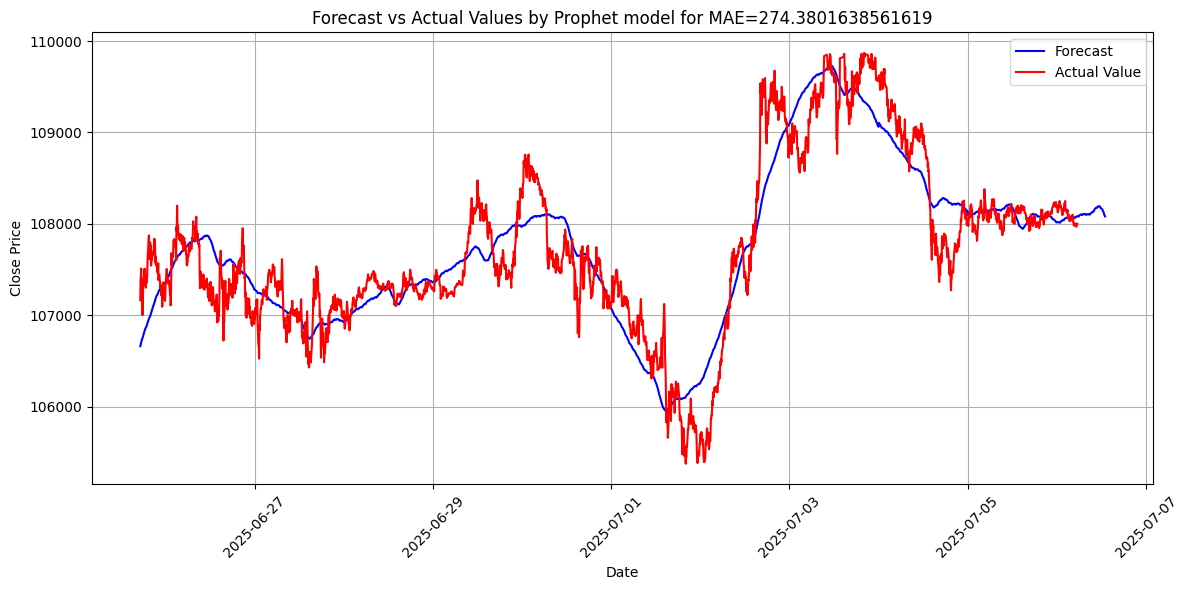

In [8]:
plt.figure(figsize=(12, 6))
result['Close'] = pd.to_numeric(result['Close'])
plt.plot(result['ds'], result['yhat'], 'b-', label='Forecast')
plt.plot(result['ds'], result['Close'], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Close Price')
plt.title(f'Forecast vs Actual Values by Prophet model for MAE={mae}')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

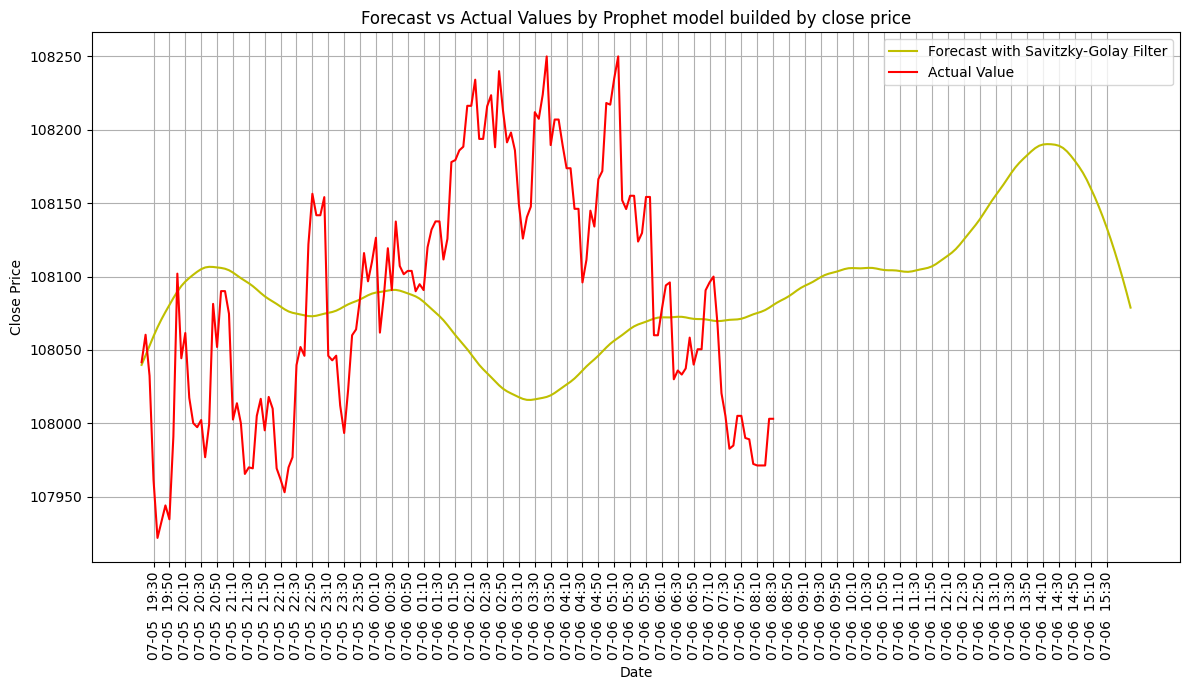

In [9]:
amount_of_5min = 250
plt.figure(figsize=(12, 7))

result['yhat_savgol_filter'] = savgol_filter(result['yhat'], window_length=21, polyorder=2) # to make the yhat smoother

result['Close'] = pd.to_numeric(result['Close'])
result['ds'] = result['ds'] + pd.to_timedelta(3, unit='h') # added + 3h to UTC time
#plt.plot(result['ds'].iloc[-amount_of_5min:], result['yhat'].iloc[-amount_of_5min:], 'b-', label='Forecast')
plt.plot(result['ds'].iloc[-amount_of_5min:], result['yhat_savgol_filter'].iloc[-amount_of_5min:], 'y-', label='Forecast with Savitzky-Golay Filter')
plt.plot(result['ds'].iloc[-amount_of_5min:], result['Close'].iloc[-amount_of_5min:], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')

tick_dates= pd.date_range(start = result['ds'].iloc[-amount_of_5min:].min().ceil('30 min'), 
                          end = result['ds'].iloc[-amount_of_5min:].max().floor('30 min'), 
                          periods = 61)
plt.xticks(tick_dates, rotation=90)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d  %H:%M'))

plt.ylabel('Close Price')
plt.title('Forecast vs Actual Values by Prophet model builded by close price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
# Save the plot with date and time in the filename
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
plt.savefig(f'{symbol}_forecast_{timestamp}.png')  # Save with timestamp

output_path = os.path.join('..', 'charts', f'5m_{symbol}_forecast_Prophet_{timestamp}.png')

plt.savefig(output_path)

plt.show()

# Plotting partst of the forecast:
-Actual data points (black dots)

-Forecast line (yhat)

-Uncertainty bands (yhat_lower, yhat_upper)

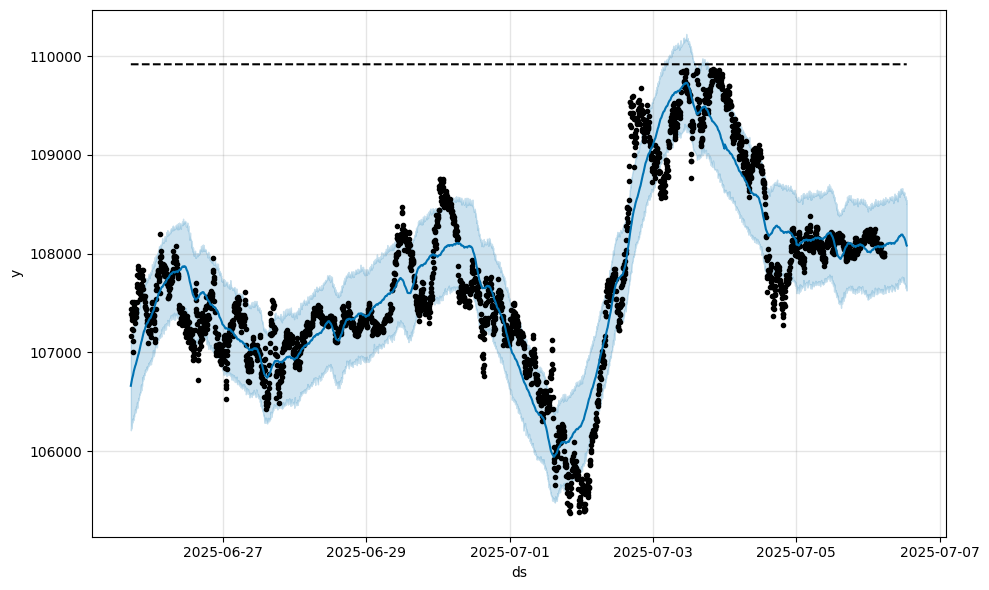

In [10]:
fig1 = m.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)
plt.show()

# Visualizes individual model components:

-Trend

-Weekly seasonality

-Yearly seasonality

-Holidays (if added)

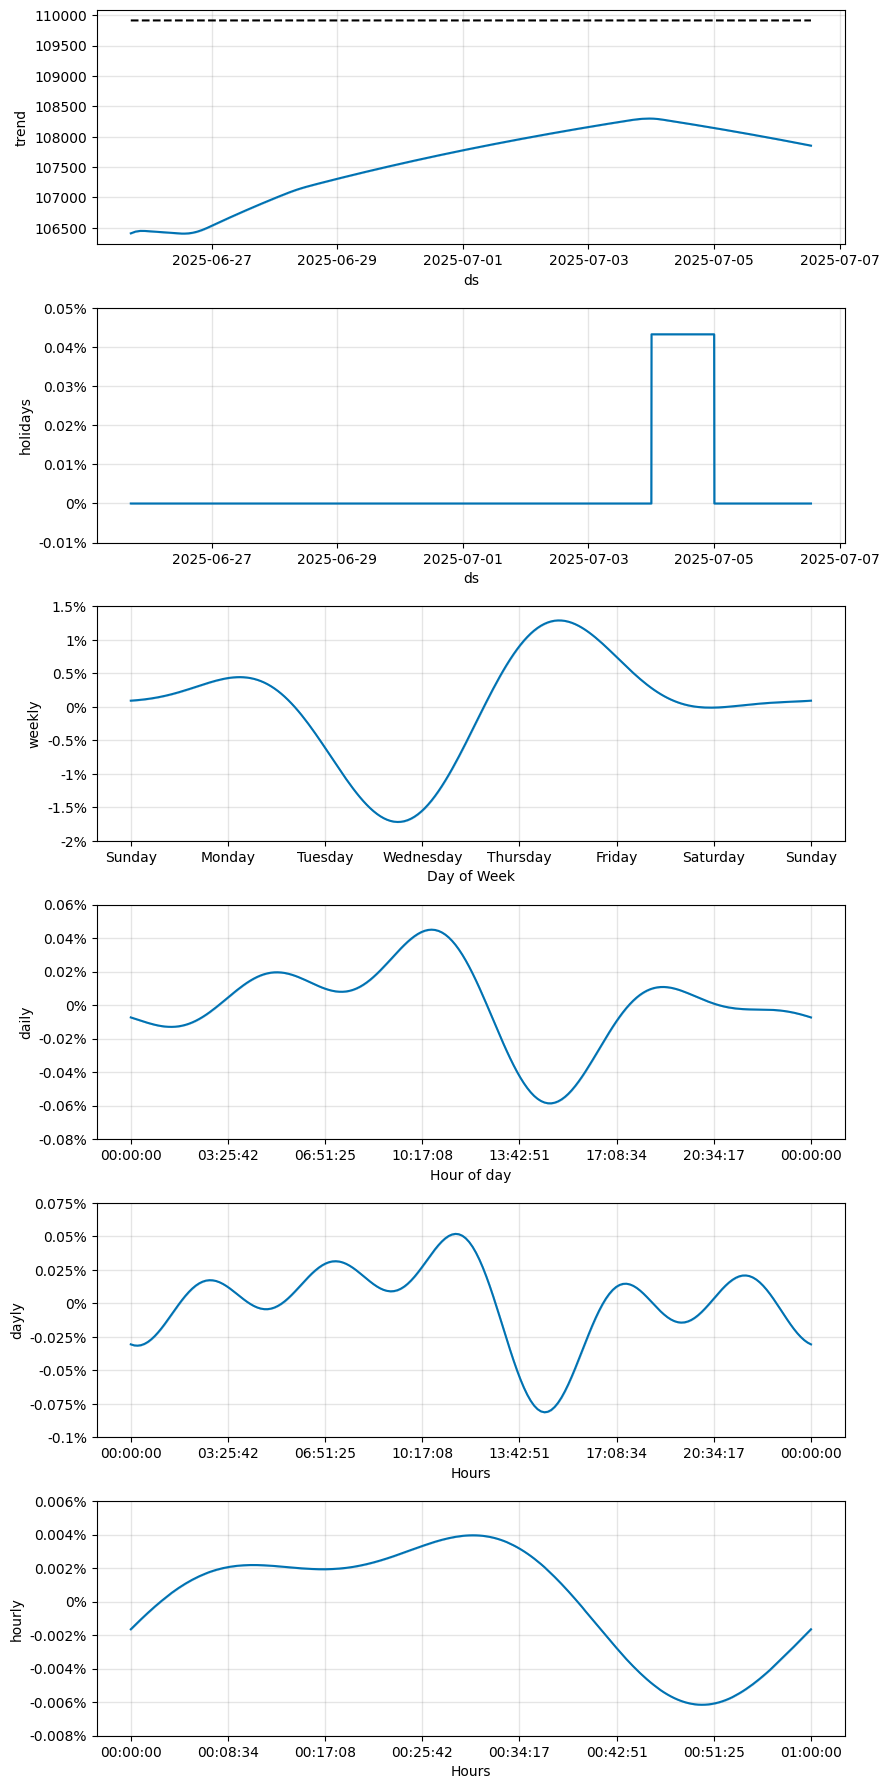

In [11]:
fig2 = m.plot_components(forecast)
plt.show()

In [12]:
result[['ds','yhat','Close','Date']].to_csv('forecast_course.csv' )